# Codebase for SweetOrigins
- best to run in given order
- some legacy code (to build substitution matrix etc.) is commented out

In [1]:
import matplotlib
import matplotlib.mlab
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from matplotlib import cm
%matplotlib inline  
from google.colab import drive
drive.mount('/content/drive')
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics.pairwise import cosine_similarity, paired_distances
from sklearn.metrics import accuracy_score, confusion_matrix, matthews_corrcoef
from sklearn.manifold import TSNE
from scipy.spatial.distance import pdist, squareform, euclidean, cosine
from scipy.cluster.hierarchy import dendrogram, linkage
import scipy.spatial.distance as ssd
import scipy.cluster.hierarchy as hcluster
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import average, to_tree
import scipy
import pandas as pd
import random
import string
import numpy as np
import time, copy
import re
import ast
import umap
import seaborn as sns
import heapq
from collections import Counter
import itertools
from itertools import compress
import operator
import pickle

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
!pip install git+https://github.com/NVIDIA/apex
from apex import amp

!pip install git+git://github.com/Bribak/python-alignment.git
from alignment.sequence import Sequence
from alignment.vocabulary import Vocabulary
from alignment.sequencealigner import SimpleScoring, SubstitutionScoring, GlobalSequenceAligner, LocalSequenceAligner

!pip install scikit-bio
from skbio.tree import nj
from skbio import DistanceMatrix

!pip install joypy
import joypy

  Cloning https://github.com/NVIDIA/apex to /tmp/pip-req-build-6vs0xo12
  Running command git clone -q https://github.com/NVIDIA/apex /tmp/pip-req-build-6vs0xo12
  Running command git submodule update --init --recursive -q
  Created wheel for apex: filename=apex-0.1-cp36-none-any.whl size=153249 sha256=757f93ded2129f89011ba6acd93ecc65831a56cd551ed80d9d57c0a0638b29e9
  Stored in directory: /tmp/pip-ephem-wheel-cache-wc5jthhk/wheels/91/1e/dc/41a5ba86547c578bd19be9cb9bdfd90b4e797acc58377e343b
Successfully built apex
  Cloning git://github.com/Bribak/python-alignment.git to /tmp/pip-req-build-6us__42i
  Running command git clone -q git://github.com/Bribak/python-alignment.git /tmp/pip-req-build-6us__42i
  Created wheel for alignment: filename=alignment-1.0.10-cp36-none-any.whl size=10646 sha256=f5d7d65d38717c5f2a00bf9d758344ffa58eeee93c961a83cda1bb1c99d879b7
  Stored in directory: /tmp/pip-ephem-wheel-cache-dj1jvhrv/wheels/0b/d1/ff/d956af2d747139ba25add15ba4b7a43d353a493626d7b5876e
Success

# Helper Functions to Process Glycan Sequences

In [0]:
def motif_find(s, exhaustive = False):
  """processes glycan sequence into glycowords"""
  b = s.split('(')
  b = [k.split(')') for k in b]
  b = [item for sublist in b for item in sublist]
  b = [k.strip('[') for k in b]
  b = [k.strip(']') for k in b]
  b = [k.replace('[', '') for k in b]
  b = [k.replace(']', '') for k in b]
  if exhaustive:
    if len(b) >= 5:
      b = ['*'.join(b[i:i+5]) for i in range(0, len(b)-4, 2)]
    else:
      b = ['*'.join(b)]
  else:
    b = ['*'.join(b[i:i+5]) for i in range(0, len(b)-4, 2)]
  return b

def small_motif_find(s):
  """processes glycan sequence without splitting it into glycowords"""
  b = s.split('(')
  b = [k.split(')') for k in b]
  b = [item for sublist in b for item in sublist]
  b = [k.strip('[') for k in b]
  b = [k.strip(']') for k in b]
  b = [k.replace('[', '') for k in b]
  b = [k.replace(']', '') for k in b]
  b = '*'.join(b)
  return b

def min_process(glycan):
  """processes glycan sequences even more minimally than small_motif_find"""
  b = glycan.split('(')
  b = [k.split(')') for k in b]
  b = [item for sublist in b for item in sublist]
  b = [k.strip('[') for k in b]
  b = [k.strip(']') for k in b]
  b = [k.replace('[', '') for k in b]
  b = [k.replace(']', '') for k in b]
  return b

def process_glycans(glycan_list, exhaustive = False):
  """wrapper function to process list of glycans into glycowords"""
  glycan_motifs = [motif_find(k, exhaustive = exhaustive) for k in glycan_list]
  glycan_motifs = [[i.split('*') for i in k] for k in glycan_motifs]
  return glycan_motifs

def find_isomorphs(glycan):
  """returns a set of isomorphic glycans by swapping branches etc."""
  out_list = [glycan]
  #starting branch swapped with next side branch
  if '[' in glycan and glycan.index('[') > 0 and not bool(re.search('\[[^\]]+\[', glycan)):
    glycan2 = re.sub('^(.*?)\[(.*?)\]', r'\2[\1]', glycan, 1)
    out_list.append(glycan2)
  #double branch swap
  temp = []
  for k in out_list:
    if '][' in k:
      glycan3 = re.sub('(\[.*?\])(\[.*?\])', r'\2\1', k)
      temp.append(glycan3)
  #starting branch swapped with next side branch again to also include double branch swapped isomorphs
  temp2 = []
  for k in temp:
    if '[' in k and k.index('[') > 0 and not bool(re.search('\[[^\]]+\[', k)):
      glycan4 = re.sub('^(.*?)\[(.*?)\]', r'\2[\1]', k, 1)
      temp2.append(glycan4)
  return list(set(out_list + temp + temp2))

def isomorph_database(glycan_database):
  """wrapper function to convert glycans in database into their set of isomorphic glycans"""
  try:
    glycans = list(set(glycan_database.glycan.values.tolist()))
    df = [find_isomorphs(k) for k in glycans]
    df.sort()
    df = list(k for k,_ in itertools.groupby(df))
  except:
    glycans = glycan_database.target.values.tolist()
    df = [find_isomorphs(k) for k in glycans]
    for k in df:
      k.sort()
  #df = pd.DataFrame(df)
  return df

def character_to_label(character, libr):
  """returns vocab label for a character"""
  character_label = libr.index(character)
  return character_label

def string_to_labels(character_string, libr):
  """maps glycan sequence to list of vocab labels"""
  return list(map(lambda character: character_to_label(character, libr), character_string))

# Load Dataset of Unique Glycans for Language Model Training

In [4]:
df_all = pd.read_csv('data_files/new_unique_glycans.csv')
print(len(df_all))
df_all = isomorph_database(df_all)
df_all = list(set([item for sublist in df_all for item in sublist]))
print(len(df_all))
df_all = process_glycans(df_all, exhaustive = True)
df_all = [item for sublist in df_all for item in sublist]

lib_all = list(sorted(list(set([item for sublist in df_all for item in sublist]))))
lib_size_all = len(lib_all)
print(lib_size_all)

def pad_sequence(seq, max_length, pad_label = lib_size_all):
  """add padding as new label"""
  seq += [pad_label for i in range(max_length-len(seq))]
  return seq

19299
31416
1028


# Define Dataset Class for Language Model

In [0]:
class SugarDataset(data.Dataset):
  def __init__(self, df, libr, libr_size = lib_size_all, padding = False):
    self.df = df
    self.libr = libr
    self.libr_size = libr_size
    self.padding = padding
    self.max_len = len(max(self.df, key = len))
    self.idx = range(len(self.df)) 
    
  def __len__(self):
    return len(self.idx)
  
  def __getitem__(self, index):
    index = self.idx[index]
    raw_string = self.df[index]
    string_labels = string_to_labels(raw_string, self.libr)
    seq_length = len(string_labels)-1
    
    input_string_labels = string_labels[:-1]
    output_string_labels = string_labels[1:]

    if self.padding:
      input_string_labels = pad_sequence(input_string_labels, max_length = self.max_len, pad_label = self.libr_size)
      output_string_labels = pad_sequence(output_string_labels, max_length = self.max_len, pad_label = self.libr_size)
    
    return (torch.LongTensor(input_string_labels),
           torch.LongTensor(output_string_labels),
           torch.LongTensor([seq_length]))
  
def post_process_sequence_batch(batch_tuple):
    input_seq, output_seq, seq_length = batch_tuple
    split_input_seq_batch = input_seq.split(split_size = 1)
    split_output_seq_batch = output_seq.split(split_size = 1)
    split_length_batch = seq_length.split(split_size = 1)
    
    train_data_tuples = zip(split_input_seq_batch,
                         split_output_seq_batch,
                         split_length_batch)
    sorted_train_data = sorted(train_data_tuples,
                            key = lambda p:int(p[2]),
                            reverse = True)
    split_input_batch, split_output_batch, split_length_batch = zip(*sorted_train_data)
    input_seq_sorted = torch.cat(split_input_batch)
    output_seq_sorted = torch.cat(split_output_batch)
    length_sorted = torch.cat(split_length_batch)
    
    input_seq_sorted = input_seq_sorted[:, :length_sorted[0,0]]
    output_seq_sorted = output_seq_sorted[:, :length_sorted[0,0]]
    
    input_seq_transposed = input_seq_sorted.transpose(0,1)
    
    length_sorted_list = list(length_sorted)
    length_sorted_list = list(map(lambda x: int(x), length_sorted_list))
    
    return input_seq_transposed, output_seq_sorted, length_sorted_list

#Prepare Data for Language-Language Model

In [0]:
df2_char = [list(''.join(k)) for k in df_all]
lib_char = list(sorted(list(set([item for sublist in df2_char for item in sublist]))))
lib_size_char = len(lib_char)
train_char, val_char = train_test_split(df2_char, test_size = 0.2, shuffle = True)

trainset_char = SugarDataset(train_char, lib_char, libr_size = lib_size_char, padding = True)
trainset_loader_char = data.DataLoader(trainset_char, batch_size = 256,
                               shuffle = True, num_workers = 0, pin_memory = True)

valset_char = SugarDataset(val_char, lib_char, libr_size = lib_size_char, padding = True)
valset_loader_char = data.DataLoader(valset_char, batch_size = 64,
                             shuffle = False)

dataloaders = {'train':trainset_loader_char, 'val':valset_loader_char}
dataset_sizes = {'train':len(train_char), 'val':len(val_char)}

In [0]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience = 7, verbose = False):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = 0

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        #torch.save(model.state_dict(), 'drive/My Drive/checkpoint.pt')
        self.val_loss_min = val_loss

# Training Loop Function

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs = 25, padding = False):
  since = time.time()
  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 100.0
  val_losses = []
  val_perplexities = []
  
  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-'*10)
    
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()
        
      running_loss = []
      running_perplexity = []
      for inputs, outputs, lengths in dataloaders[phase]:
        if padding:
          post_processed_batch_tuple = post_process_sequence_batch((inputs, outputs, lengths))
          inputs, outputs, lengths = post_processed_batch_tuple
        inputs = inputs.cuda()
        outputs = outputs.contiguous().view(-1).cuda()
        optimizer.zero_grad()
        
        with torch.set_grad_enabled(phase == 'train'):
          pred,_ = model(inputs, lengths)
          loss = criterion(pred,outputs)
          if phase == 'train':
            with amp.scale_loss(loss, optimizer) as scaled_loss:
              scaled_loss.backward()
            optimizer.step()
            
        running_loss.append(loss.item())
        running_perplexity.append(np.exp(loss.item()))
        
      epoch_loss = np.mean(running_loss)
      epoch_perplexity = np.mean(running_perplexity)
      print('{} Loss: {:.4f} Perplexity: {:.4f}'.format(
          phase, epoch_loss, epoch_perplexity))
      
      if phase == 'val' and epoch_loss <= best_loss:
        best_loss = epoch_loss
        best_model_wts = copy.deepcopy(model.state_dict())
      if phase == 'val':
        val_losses.append(epoch_loss)
        val_perplexities.append(epoch_perplexity)
        early_stopping(epoch_loss, model)

      scheduler.step()
        
    if early_stopping.early_stop:
      print("Early stopping")
      break
    print()
    
  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(
      time_elapsed // 60, time_elapsed % 60))
  print('Best val Perplexity: {:4f}'.format(best_loss))
  model.load_state_dict(best_model_wts)

  ## plot loss & perplexity over the course of training 
  fig, ax = plt.subplots(nrows = 2, ncols = 1) 
  plt.subplot(2, 1, 1)
  plt.plot(range(epoch+1), val_losses)
  plt.title('Training of SweetTalk')
  plt.ylabel('Validation Loss')
  plt.legend(['Validation Loss'],loc = 'best')

  plt.subplot(2, 1, 2)
  plt.plot(range(epoch+1), val_perplexities)
  plt.ylabel('Validation Perplexity')
  plt.xlabel('Number of Epochs')
  plt.legend(['Validation Perplexity'], loc = 'best')
  return model

# Defining the Language Model

In [0]:
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes, n_layers = 2):
    super(RNN, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.num_classes = num_classes
    self.n_layers = n_layers
    
    self.encoder = nn.Embedding(input_size, hidden_size, padding_idx = self.num_classes-1)
    self.decoder = nn.Linear(hidden_size, num_classes)
    self.gru = nn.LSTM(hidden_size, hidden_size, n_layers, bidirectional = True)
    self.logits_fc = nn.Linear(2*hidden_size, num_classes)   
    
  def forward(self, input_seq, input_seq_len, hidden = None):
    batch_size = input_seq.shape[1]
    self.bn1 = nn.BatchNorm1d(batch_size).cuda()
    embedded = self.bn1(self.encoder(input_seq))
    
    packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, input_seq_len)
    outputs, (h_n, c_n) = self.gru(packed, hidden)
    outputs, outputs_len = torch.nn.utils.rnn.pad_packed_sequence(outputs)
    
    logits = self.logits_fc(outputs.cuda())
    logits = logits.transpose(0,1).contiguous()
    logits_flatten = logits.view(-1, self.num_classes)
    
    return logits_flatten, hidden

# Training the Character-Based Language Model

In [10]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

model=RNN(input_size = lib_size_char+1, hidden_size = 128,
                       num_classes = lib_size_char+1)
model.apply(init_weights)
model.cuda()

early_stopping = EarlyStopping(patience = 10, verbose = True)
optimizer_ft = optim.Adam(model.parameters(), lr = 0.005)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer_ft, 100)
model, optimizer_ft = amp.initialize(model, optimizer_ft, opt_level = "O1")
criterion = nn.CrossEntropyLoss().cuda()
#model_ft = train_model(model, criterion, optimizer_ft, scheduler,
#                    num_epochs = 150, padding = True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


In [0]:
model_ft = torch.load('models/SweetTalk_large_char_exp_iso2.pt').eval()

# Load Data for Language Model

In [12]:
df_all_long = pd.read_csv('data_files/new_unique_glycans.csv')
print(len(df_all_long))
df_all_long = isomorph_database(df_all_long)
df_all_long = list(set([item for sublist in df_all_long for item in sublist]))
print(len(df_all_long))
df_all_long = process_glycans(df_all_long)
df_all_long = [item for sublist in df_all_long for item in sublist]

lib_all_long = list(sorted(list(set([item for sublist in df_all_long for item in sublist]))))
lib_size_all_long = len(lib_all_long)
print(lib_size_all_long)

19299
31416
1028


# Initialize SweetTalk Embedding with Character Embedding

In [13]:
embed_char = model_ft.encoder.weight.data.cpu().numpy()

rep = {}
for k in range(len(lib_all_long)):
  query = list(lib_all_long[k])
  query = [lib_char.index(i) for i in query]
  rep[lib_all_long[k]] = np.mean(embed_char[query,:], axis = 0)

init_emb = np.array(list(rep.values()))
init_emb = np.concatenate([init_emb,np.array([0]*128).reshape(1,-1)])
init_emb.shape

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


(1029, 128)

In [0]:
reducer = umap.UMAP(random_state = 0, transform_seed = 0)
dim_red_emb = reducer.fit_transform(init_emb[1:])
tsne_emb = TSNE(n_components = 2).fit_transform(init_emb[1:])

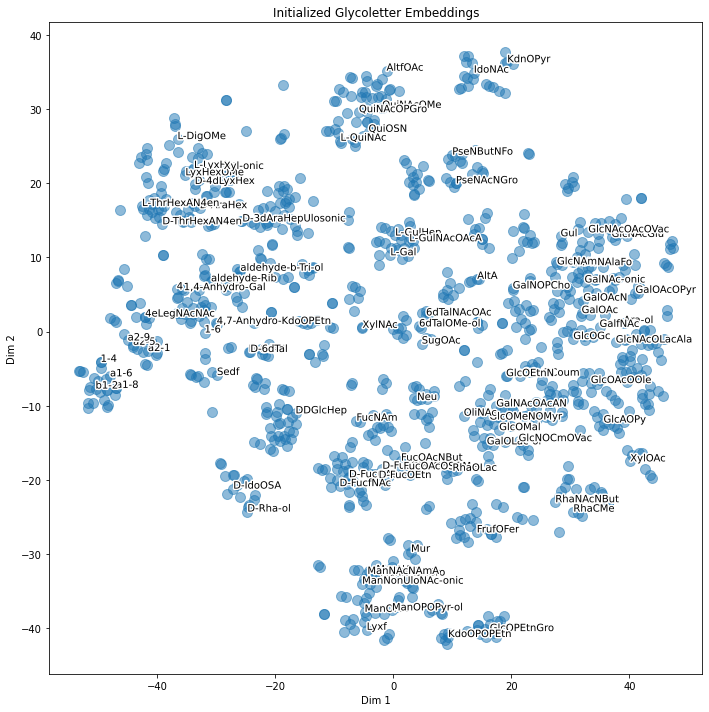

In [15]:
fig = plt.figure(figsize = (10,10))
plt.scatter(tsne_emb[:,0], tsne_emb[:,1], s = 100, alpha = 0.5)
for i, txt in enumerate(lib_all_long):
    if random.random() > 0.9:
    #if emb_dist[i] > 0.5*np.max(emb_dist):
      text = plt.annotate(txt, (tsne_emb[:,0][i], tsne_emb[:,1][i]), alpha = 1)
      text.set_path_effects([path_effects.Stroke(linewidth = 3, foreground = 'white'),
                       path_effects.Normal()])
plt.xlabel('Dim 1')
plt.ylabel('Dim 2')
plt.title('Initialized Glycoletter Embeddings')
plt.tight_layout()

# Prepare Data for Language Model & Training

In [0]:
train, val = train_test_split(df_all_long, test_size = 0.2, shuffle = True)

trainset = SugarDataset(train, lib_all_long)
trainset_loader = data.DataLoader(trainset, batch_size = 256,
                               shuffle = True, num_workers = 4, pin_memory = True)

valset = SugarDataset(val, lib_all_long)
valset_loader = data.DataLoader(valset, batch_size = 64,
                             shuffle = False)

dataloaders = {'train':trainset_loader, 'val':valset_loader}
dataset_sizes = {'train':len(train), 'val':len(val)}

In [0]:
class SweetTalk(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes, n_layers = 2):
    super(SweetTalk,self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.num_classes = num_classes
    self.n_layers = n_layers
    
    self.encoder = nn.Embedding(input_size, hidden_size, padding_idx = self.num_classes-1)
    self.decoder = nn.Linear(hidden_size, num_classes)
    self.gru = nn.LSTM(hidden_size, hidden_size, n_layers, bidirectional = True)
    self.logits_fc = nn.Linear(2*hidden_size, num_classes)
    
  def forward(self, input_seq, input_seq_len, hidden = None):
    batch_size = input_seq.shape[1]
    self.bn1 = nn.BatchNorm1d(batch_size).cuda()
    embedded = self.bn1(self.encoder(input_seq))
    
    outputs, (h_n, c_n) = self.gru(embedded,hidden)
    
    logits = self.logits_fc(outputs)
    logits = logits.transpose(0,1).contiguous()
    logits_flatten = logits.view(-1, self.num_classes)
    
    return logits_flatten, hidden

In [18]:
model = SweetTalk(input_size = lib_size_all_long, hidden_size = 128,
                       num_classes = lib_size_all_long)
model.apply(init_weights)
model.encoder.weight.data = torch.from_numpy(init_emb[1:]).float()
model.cuda()

early_stopping = EarlyStopping(patience = 10, verbose = True)
optimizer_ft = optim.Adam(model.parameters(), lr = 0.01)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer_ft, 100)
model, optimizer_ft = amp.initialize(model, optimizer_ft, opt_level = "O1")
criterion = nn.CrossEntropyLoss().cuda()
#model_ft = train_model(model, criterion, optimizer_ft, scheduler,
#                    num_epochs = 150)

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
model_ft = torch.load('models/SweetTalk_large_exp_iso2.pt').eval()
embed = model_ft.encoder.weight.data.cpu().numpy()

# Visualize Embedding Difference Between Character- and Glycoletter-based Training

In [0]:
reducer = umap.UMAP(random_state = 0, transform_seed = 0)
dim_red_emb = reducer.fit_transform(embed)
tsne_emb = TSNE(n_components = 2).fit_transform(embed)

In [0]:
emb_dist = paired_distances(init_emb[1:], embed)

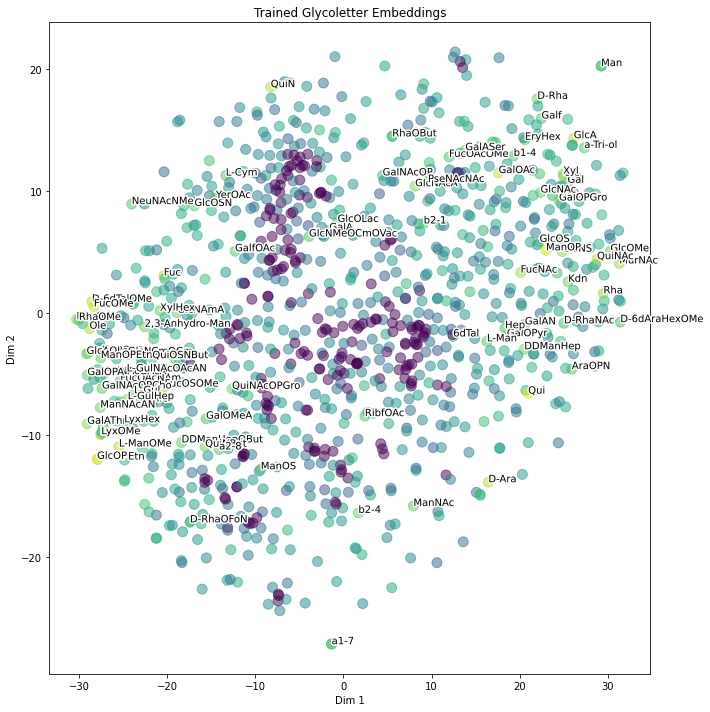

In [22]:
fig = plt.figure(figsize = (10,10))
plt.scatter(tsne_emb[:,0], tsne_emb[:,1], s = 100, alpha = 0.5, c = emb_dist, cmap = 'viridis')
for i, txt in enumerate(lib_all_long):
  if emb_dist[i] > 0.7*np.max(emb_dist):
    text = plt.annotate(txt, (tsne_emb[:,0][i], tsne_emb[:,1][i]))
    text.set_path_effects([path_effects.Stroke(linewidth = 3, foreground = 'white'),
                       path_effects.Normal()])
plt.xlabel('Dim 1')
plt.ylabel('Dim 2')
plt.title('Trained Glycoletter Embeddings')
plt.tight_layout()
#plt.colorbar()

# Visualizing Learned Glycoword Embeddings

In [23]:
#number of unique glycowords in dataset
len(list(set([tuple(k) for k in df_all_long])))

19866

In [24]:
#counting glycoword occurrence & converting them to lists of labels
words = list(sorted(list(set([tuple(string_to_labels(k, lib_all_long)) for k in df_all_long]))))
words_label = list(sorted(list(set([tuple(k) for k in df_all_long]))))
print(words[0])

cou = Counter([tuple(k) for k in df_all_long])
freqs = [cou[k] for k in words_label]

(11, 980, 406, 980, 406)


In [0]:
#calculating glycoword embeddings
rep = {}
for k in range(len(words)):
  rep[words_label[k]] = np.mean(embed[list(words[k]), :], axis = 0)

In [26]:
reducer2 = umap.UMAP(random_state = 0, transform_seed = 0)
dim_red_emb2 = reducer2.fit_transform(pd.DataFrame.from_dict(rep).T)
tsne_emb2 = TSNE(n_components = 2).fit_transform(pd.DataFrame.from_dict(rep).T)

/usr/local/lib/python3.6/dist-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../usr/local/lib/python3.6/dist-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/usr/local/lib/python3.6/dist-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../usr/local/lib/python3.6/dist-packages/umap/utils.py", line 409:
@numba.njit(parallel=True

In [0]:
#representative bonds and monosaccharides
bonds = ['a1-2', 'a1-3', 'a2-3', 'a1-4', 'a1-5', 'a1-6', 'a2-6', 'a2-8',
         'b1-2', 'b1-3', 'b1-4', 'b1-6']

sugars = ['Ara', 'Fuc', 'FucNAc', 'Gal', 'GalA', 'GalNAc', 'GalOAc', 'Galf',
          'Glc', 'GlcA', 'GlcNAc', 'GlcOAc', 'Man', 'ManNAc',
          'NeuNAc', 'NeuNGc', 'Qui', 'QuiNAc', 'Rha', 'Xyl']

In [0]:
#more comprehensive lists of monosaccharides/bonds
all_bonds = ['a1-1', 'a1-2', 'a1-3', 'a1-4', 'a1-5', 'a1-6', 'a1-7', 'a1-8',
             'a2-1', 'a2-2', 'a2-3', 'a2-4', 'a2-5', 'a2-6', 'a2-7', 'a2-8',
             'a2-9', 'a6-6', 'b1-1', 'b1-2', 'b1-3', 'b1-4', 'b1-5', 'b1-6', 'b1-7',
             'b1-8', 'b1-9', 'b2-1', 'b2-2', 'b2-3', 'b2-4', 'b2-5', 'b2-6',
             'b2-7', 'b2-8', 'b3-3']
all_sugars = [k for k in lib_all_long if k not in all_bonds]
all_sugars = [k for k in all_sugars if k not in ['', '1', '1-3', '1-4', '1-6',
                                                 '2-6', '3', '3-3', '3-5', '3-6',
                                                 '4', '5-2', '5-3', '5-6']]

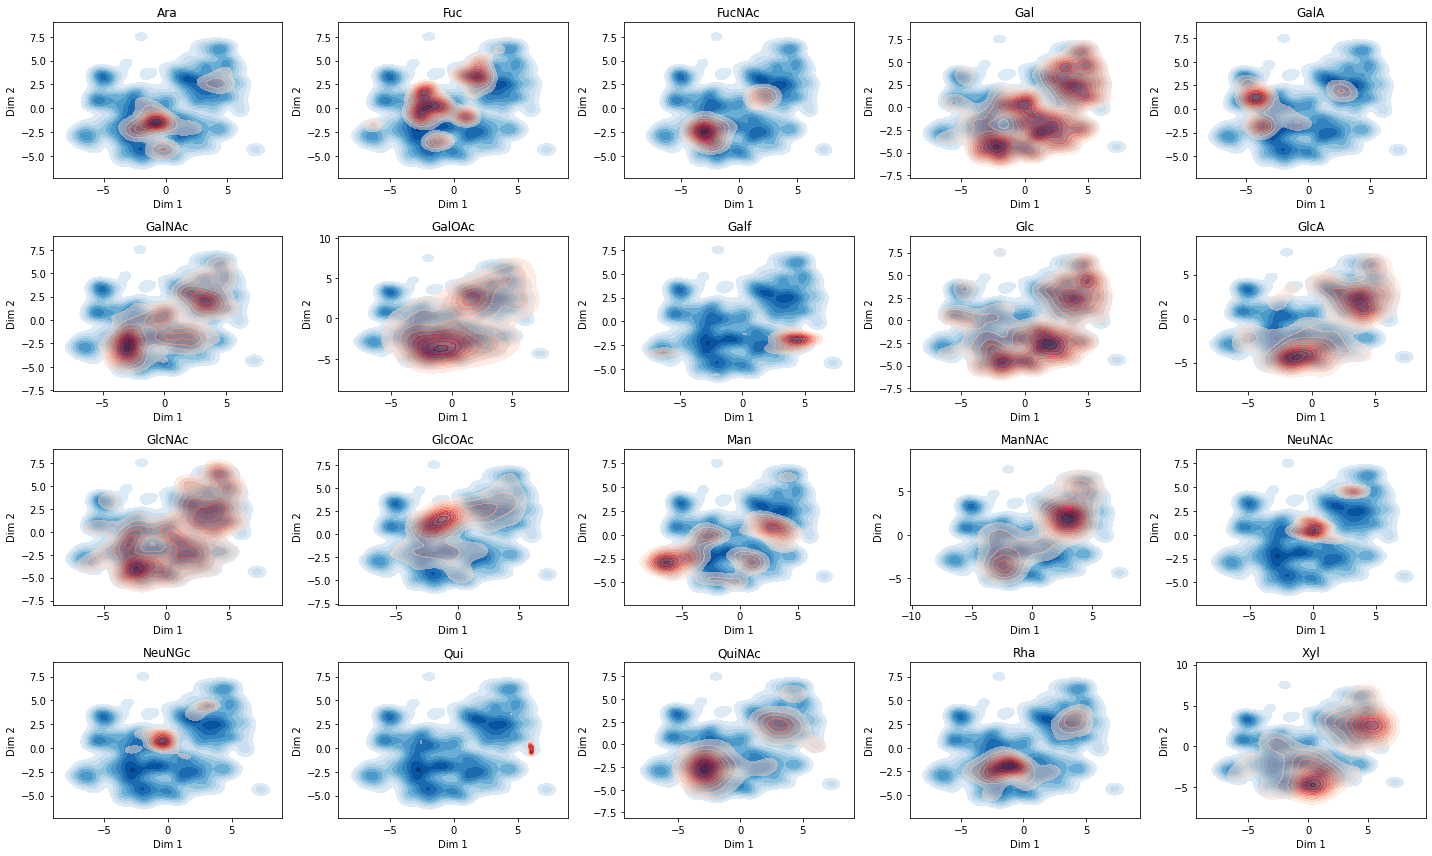

In [29]:
#replace all occurrences of "sugars" with "bonds" and change subplot to 3,4 for visualizing bonds
plt.figure(figsize = (20,12))
for i in range(len(sugars)):
  plt.subplot(4, 5, i+1)
  gals = [True if sugars[i] in k else False for k in list(rep.keys())]
  sns.kdeplot(dim_red_emb2[:,0], dim_red_emb2[:,1], cmap = "Blues", shade = True, shade_lowest = False)
  sns.kdeplot(dim_red_emb2[gals,0], dim_red_emb2[gals,1], cmap = "Reds", alpha = 0.5, shade = True, shade_lowest = False)
  plt.xlabel('Dim 1')
  plt.ylabel('Dim 2')
  plt.title('%s' % sugars[i])
plt.tight_layout()

Text(0, 0.5, 'Density')

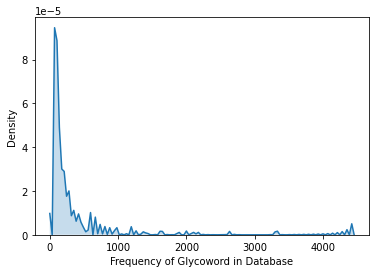

In [30]:
#visualizes frequency distribution of glycowords
sns.kdeplot(np.array(list(Counter(cou).values())), bw = 0.1, shade = True)
plt.xlabel('Frequency of Glycoword in Database')
plt.ylabel('Density')

Text(0.5, 0, 'Frequency in Database')

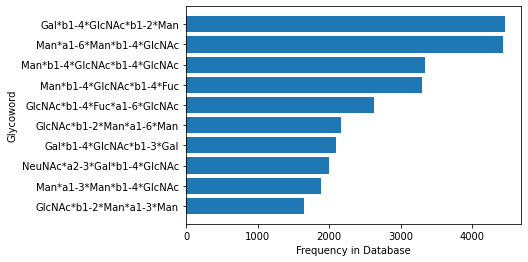

In [31]:
#get sorted glycoword frequencies and plots most frequent ones
freqs = [cou[k] for k in words_label]
comb = sorted(zip(freqs, words_label), key = lambda x: x[0])
s_freqs, s_words_label = zip(*comb)
s_words_label = ['*'.join(list(k)) for k in s_words_label]
plt.barh(range(10), s_freqs[-10:])
plt.yticks(range(10), s_words_label[-10:])
plt.ylabel('Glycoword')
plt.xlabel('Frequency in Database')

# Glycan Alignments

In [0]:
#substitution matrix
df_sub4 = pd.read_csv('data_files/df_glyco_substitution_iso2.csv')
df_sub4 = df_sub4.iloc[:,1:]

In [33]:
#process glycans with species information as an alignment database
df_species2 = pd.read_csv('data_files/glyco_targets_species_seq_all_V2clean.csv')
df_spec = copy.deepcopy(df_species2)
df_species2.domain = [k.strip() for k in df_species2.domain.values.tolist()]
df_species2.kingdom = [k.strip() for k in df_species2.kingdom.values.tolist()]
df_species2.phylum = [k.strip() for k in df_species2.phylum.values.tolist()]
df_species2['class'] = [k.strip() for k in df_species2['class'].values.tolist()]
df_species2.order = [k.strip() for k in df_species2.order.values.tolist()]
df_species2.family = [k.strip() for k in df_species2.family.values.tolist()]
df_species2.genus = [k.strip() for k in df_species2.genus.values.tolist()]
df_species2.target = [small_motif_find(k) for k in df_species2.target.values.tolist()]
df_species2

,target,species,genus,family,order,class,phylum,kingdom,domain
0,Man*a1-3*Man*a1-6*Xyl*b1-2*Man*b1-4*GlcNAc*b1-...,Acer_pseudoplatanus,Acer,Sapindaceae,Sapindales,Dicotyledons,Angiosperms,Plantae,Eukarya
1,GlcNAc*b1-2*Man*a1-3*Man*a1-6*Xyl*b1-2*Man*b1-...,Acer_pseudoplatanus,Acer,Sapindaceae,Sapindales,Dicotyledons,Angiosperms,Plantae,Eukarya
2,GlcNAc*b1-2*Man*a1-6*Man*a1-3*Xyl*b1-2*Man*b1-...,Acer_pseudoplatanus,Acer,Sapindaceae,Sapindales,Dicotyledons,Angiosperms,Plantae,Eukarya
3,Fuc*a1-6*Gal*b1-4*GlcNAc*b1-2*Man*a1-6*GlcNAc*...,Acer_pseudoplatanus,Acer,Sapindaceae,Sapindales,Dicotyledons,Angiosperms,Plantae,Eukarya
4,GlcNAc*b1-2*Man*a1-3*GlcNAc*b1-2*Man*a1-6*Xyl*...,Acer_pseudoplatanus,Acer,Sapindaceae,Sapindales,Dicotyledons,Angiosperms,Plantae,Eukarya
...,...,...,...,...,...,...,...,...,...
12669,QuiNAc*b1-7*LDManHep*a1-6*Glc*a1-2*Glc*a1-3*Glc,Escherichia_coli,Escherichia,Enterobacteriaceae,Enterobacterales,Gammaproteobacteria,Proteobacteria,Bacteria,Bacteria
12670,Rha*a1-3*Rha*a1-4*GalNAcA*a1-3*GlcNAc*b1-2*Rha,Escherichia_coli,Escherichia,Enterobacteriaceae,Enterobacterales,Gammaproteobacteria,Proteobacteria,Bacteria,Bacteria
12671,LDManHep*a1-6*Glc*a1-2*Glc,Escherichia_coli,Escherichia,Enterobacteriaceae,Enterobacterales,Gammaproteobacteria,Proteobacteria,Bacteria,Bacteria
12672,Gal*a1-3*FucNAc*a1-3*GlcNAc*b1-3*Rib-ol,Escherichia_coli,Escherichia,Enterobacteriaceae,Enterobacterales,Gammaproteobacteria,Proteobacteria,Bacteria,Bacteria


In [0]:
def pairwiseAlign(query, corpus, n = 5, database = df_species2, vocab = (all_sugars+all_bonds),
                  submat = df_sub4, mismatch = -10, gap = -5, self_contain = True, query_in_corpus = True):
  """aligns glycan sequence from database against rest of the database and returns the best n alignments"""
  if n == 0:
    n = len(corpus)
  seqs = database.target.values.tolist()
  if query_in_corpus:
    a_in = seqs[query].split('*')
  else:
    a_in = query.split('*')
  a = Sequence(a_in)
  v = Vocabulary()
  voc = v.encodeSequence(Sequence(vocab))
  a_enc = v.encodeSequence(a)
  scoring = SubstitutionScoring(submat, mismatch)
  aligner = GlobalSequenceAligner(scoring, gap)
  specs = database.species.values.tolist()
  track = []

  for k in range(len(corpus)):
    b = Sequence(seqs[corpus[k]].split('*'))
    b_enc = v.encodeSequence(b)
    score, encodeds = aligner.align(a_enc, b_enc, backtrace = True)
    track.append((score, encodeds, corpus[k], specs[corpus[k]], len(b)))

  track.sort(key = operator.itemgetter(0), reverse = True)
  if self_contain:
    for k in track[1:n+1]:
      score,encodeds,idx,species,length = k
      for encoded in encodeds:
        alignment = v.decodeSequenceAlignment(encoded)
        print(str(a_in.index(alignment[0][0])+1),
            len(alignment)*' '*5,
            str((len(a)+1)-(a_in[::-1].index(alignment[-1][0])+1)))
        print(alignment)
        print('Alignment Score:', alignment.score)
        print('Percent Identity:', alignment.percentIdentity())
        print('Percent Coverage:', min([(len(alignment)/len(a))*100, 100.0]))
        print('Sequence Index:', idx)
        print('Species:', species)
        print()
  else:
    for k in track[:n]:
      score,encodeds,idx,species,length = k
      for encoded in encodeds:
        alignment = v.decodeSequenceAlignment(encoded)
        print(str(a_in.index(alignment[0][0])+1),
            len(alignment)*' '*5,
            str((len(a)+1)-(a_in[::-1].index(alignment[-1][0])+1)))
        print(alignment)
        print('Alignment Score:', alignment.score)
        print('Percent Identity:', alignment.percentIdentity())
        print('Percent Coverage:', min([(len(alignment)/len(a))*100, 100.0]))
        print('Sequence Index:', idx)
        print('Species:', species)
        print()

def seq2emb(glycan_list, embed = embed):
  """converts glycan sequences to trained embeddings"""
  if '(' in glycan_list[0]:
    emb = process_glycans(glycan_list)
  else:
    emb = [k.split('*') for k in glycan_list]
    emb = [['*'.join(k[i:i+5]) for i in range(0, len(k)-4, 2)] for k in emb]
    emb = [[i.split('*') for i in k] for k in emb]
  emb = [[string_to_labels(k, lib_all_long) for k in j] for j in emb]
  emb = [[np.mean(embed[k,:], axis = 0) for k in j] for j in emb]
  emb = [np.mean(k, axis = 0) for k in emb]
  return emb

In [35]:
#example: S. aureus serotype 5 capsular polysaccharide
pairwiseAlign(12579, range(len(df_species2)), n = 10)

1                                     7
ManNAcA b1-4 GlcNAc a1-3 D-FucNAc a1-4 ManNAcA
ManNAcA b1-4 GlcNAc a1-3 FucNAc   a1-4 ManNAcA
Alignment Score: 31
Percent Identity: 85.71428571428571
Percent Coverage: 100.0
Sequence Index: 12086
Species: Escherichia_coli

1                                     7
ManNAcA b1-4 GlcNAc    a1-3 D-FucNAc a1-4 ManNAcA
ManNAcA b1-4 GlcNAcOAc a1-3 D-FucNAc a1-4 ManNAcA
Alignment Score: 30
Percent Identity: 85.71428571428571
Percent Coverage: 100.0
Sequence Index: 1473
Species: Yersinia_pestis

1                                     7
ManNAcA b1-4 GlcNAc    a1-3 D-FucNAc a1-4 ManNAcA
ManNAcA b1-4 GlcNAcOAc a1-3 D-FucNAc a1-4 ManNAcA
Alignment Score: 30
Percent Identity: 85.71428571428571
Percent Coverage: 100.0
Sequence Index: 1475
Species: Yersinia_pestis

1                           5
ManNAcA b1-4 GlcNAc a1-3 D-FucNAc
ManNAcA b1-4 GlcNAc a1-3 D-FucNAc
Alignment Score: 25
Percent Identity: 100.0
Percent Coverage: 71.42857142857143
Sequence Index: 1454
Spec

# Glycan Alignment-Based Phylogenetics

In [0]:
def pairwiseAlignScore(query, target, vocab = (all_sugars+all_bonds),
                  submat = df_sub4, mismatch = -5, gap = -5):
  """aligns glycan against list of glycans and returns average alignment score"""
  
  a = Sequence(query.split('*'))
  v = Vocabulary()
  voc = v.encodeSequence(Sequence(vocab))
  a_enc = v.encodeSequence(a)
  scoring = SubstitutionScoring(submat, mismatch)
  aligner = GlobalSequenceAligner(scoring, gap)
  track = []

  for k in range(len(target)):
    b = Sequence(target[k].split('*'))
    b_enc = v.encodeSequence(b)
    score, encodeds = aligner.align(a_enc, b_enc, backtrace = True)
    track.append(score)

  return np.mean(track)

def species_alignment_score(a, b, rank = 'species', database = df_species2):
  """wrapper function to get average alignment score between glycans of two groups"""
  glyA = database[database[rank] == a].target.values.tolist()
  glyB = database[database[rank] == b].target.values.tolist()
  trackA = np.mean([pairwiseAlignScore(k, glyB) for k in glyA])
  return trackA

def pd_fill_diagonal(df_matrix, value = 0):
  """fills diagonal of matrix with specified value"""
  mat = df_matrix.values
  ind = df_matrix.index.values.tolist()
  cols = df_matrix.columns.values.tolist()
  n = mat.shape[0]
  mat[range(n), range(n)] = value
  return pd.DataFrame(mat, index = ind, columns = cols)

def distanceMat_from_alignment(rank_names, rank = 'species', database = df_species2):
  """returns distance matrix between taxonomic groups based on glycan alignments"""
  print('Running. This might take a while, so get a coffee or something.')
  comb = list(itertools.combinations(rank_names, 2))
  score_dict = {comb[k]:species_alignment_score(comb[k][0], comb[k][1],
                                                rank = rank, database = database) for k in range(len(comb))}
  df_comb = pd.Series(score_dict).reset_index()
  d = pd.DataFrame(0, index = rank_names, columns = rank_names)
  for k in range(len(score_dict)):
    d.loc[df_comb.iloc[k,0], df_comb.iloc[k,1]] = df_comb.iloc[k,2]
  d = d.fillna(0)
  d = d+d.T
  d = pd_fill_diagonal(d, np.max(d.values))
  d = d/np.max(d.values)
  d = d - 1
  d = d.apply(lambda x: abs(x))
  return d

In [0]:
#example of Bacilli as taxonomic group of interest
bacilli = df_species2[df_species2['class'] == 'Bacilli']
bacilli_min = [(bacilli.species.value_counts() >= 5).index.tolist()[k] for k in range(len((bacilli.species.value_counts() >= 5).index.tolist()))
 if (bacilli.species.value_counts() >= 5).values.tolist()[k]]
bacilli_min = list(sorted(list(set(bacilli[bacilli.species.isin(bacilli_min)].species.values.tolist()))))

bacilli = list(set(df_species2[df_species2['class']=='Bacilli']['species'].values.tolist()))
dist_mat = distanceMat_from_alignment(bacilli_min, rank='species')

# Glycan Variance + Legacy Code for GLYSUM Substitution Matrix

In [0]:
def eff_motif_find_mutate(s, mode = 'normal'): 
  """finds all allowed glycan substitutions given an alphabet"""
  collect = []
  for i in range(len(s)):
    if i % 2 == 0:
      if mode == 'normal':
        collect.append([s[:i] + [k] + s[(i+1):] if i < (len(s)-1) else s[:i] + [k] for k in sugars]) 
      elif mode == 'extreme':
        collect.append([s[:i] + [k] + s[(i+1):] if i < (len(s)-1) else s[:i] + [k] for k in all_sugars]) 
    else:
      if mode == 'normal':
        collect.append([s[:i] + [k] + s[(i+1):] if i < (len(s)-1) else s[:i] + [k] for k in bonds]) 
      elif mode == 'extreme':
        collect.append([s[:i] + [k] + s[(i+1):] if i < (len(s)-1) else s[:i] + [k] for k in all_bonds])
  collect = [item for sublist in collect for item in sublist]
  b_label = ['*'.join(b) for b in collect]
  b = [['*'.join(b[i:i+5]) for i in range(0, len(b)-4, 2)] for b in collect]
  return b, b_label

def eff_process_mutated_glycans(glycan, mode = 'normal'):
  """wrapper function to find all substitutions in glycan and return them unprocessed+processed"""
  glycan = min_process(glycan)
  wt_label = '*'.join(glycan)
  wt = ['*'.join(glycan[i:i+5]) for i in range(0, len(glycan)-4, 2)]
  wt = [i.split('*') for i in wt]
  glycan_motifs, glycan_labels = eff_motif_find_mutate(glycan, mode = mode)
  glycan_motifs = [[i.split('*') for i in k] for k in glycan_motifs]
  out = [wt] + list(glycan_motifs)
  out_labels = [wt_label] + list(glycan_labels)
  return out, out_labels

all_fast = all
lib_words = list(sorted(list(set([tuple(k) for k in df_all_long]))))
lib_words = [list(k) for k in lib_words]
fast_lib = set([tuple(k) for k in lib_words])

def eff_glycan_substitution_matrix(mat, glycan_list, mode = 'normal'):
  """runs through all allowed glycan substitutions to build a glycoletter substitution matrix"""
  n_mut = 0

  for k in range(len(glycan_list)):
    pool, pool_labels = eff_process_mutated_glycans(glycan_list[k], mode = mode)
    pool_df = [pool_labels[j] for j in range(len(pool)) if all_fast([tuple(i) in fast_lib for i in pool[j]])]
    pool_df = pd.DataFrame(pool_df, columns = ['label']).dropna().drop_duplicates(subset = 'label').reset_index(drop = True)
    temp = pool_df.label.values.tolist()[0].split('*')
    pooled = [pool_df.label.values.tolist()[j].split('*') for j in range(len(pool_df))]

    for i in range(len(temp)):
      pool_df['p' + str(i + 1)] = [j[i] for j in pooled]

    unique_pool = pool_df.iloc[:,2:].values.tolist()
    unique_pool = [item for sublist in unique_pool for item in sublist]
    unique_tokens = list(sorted(list(set(unique_pool))))

    freq = [[np.sum(pool_df['p' + str(j + 1)].str.count(r'^' + i + '$')) for j in range(len(temp))] for i in unique_tokens]
    out_df = pd.DataFrame(freq, index = unique_tokens, columns = ['p' + str(i + 1) for i in range(len(temp))])
    n_mut += (len(pool_df) - 1)

    for i in range(len(temp)):
      for j in range(len(unique_tokens)):
        if unique_tokens[j] != temp[i] and (unique_tokens[j] in all_idx) and (temp[i] in all_idx):
          mat[all_idx.index(temp[i]), all_idx.index(unique_tokens[j])] += out_df.loc[unique_tokens[j], 'p'+str(i+1)]

  return n_mut, mat

def glycan_sensitivity(glycan, mode = 'normal', out = 'binar'):
  """runs through all allowed glycan substitution to estimate variance for each glycoletter"""
  pool, pool_labels = eff_process_mutated_glycans(glycan, mode = mode)
  pool_df = [pool_labels[j] for j in range(len(pool)) if all_fast([tuple(i) in fast_lib for i in pool[j]])]
  pool_df = pd.DataFrame(pool_df, columns = ['label']).dropna().drop_duplicates(subset = 'label').reset_index(drop = True)
  temp = pool_df.label.values.tolist()[0].split('*')
  pooled = [pool_df.label.values.tolist()[j].split('*') for j in range(len(pool_df))]

  for i in range(len(temp)):
      pool_df['p' + str(i + 1)] = [j[i] for j in pooled]

  unique_pool = pool_df.iloc[:,2:].values.tolist()
  unique_pool = [item for sublist in unique_pool for item in sublist]
  unique_tokens = list(sorted(list(set(unique_pool))))

  if out == 'freq':
    freq = [[(np.sum(pool_df['p' + str(k + 1)].str.count(r'^' + i + '$')))/len(pool_df) for k in range(len(pool_df.label.values.tolist()[0].split('*')))] for i in unique_tokens]
    out_df = pd.DataFrame(freq, index = unique_tokens, columns = ['p' + str(i + 1) for i in range(len(pool_df.label.values.tolist()[0].split('*')))])
  elif out == 'weight':
    freq = [[(np.sum(pool_df['p' + str(k + 1)].str.count(r'^' + i + '$')))/len(pool_df) for k in range(len(pool_df.label.values.tolist()[0].split('*')))] for i in unique_tokens]
    freq_df = pd.DataFrame(freq, index = unique_tokens, columns = ['p' + str(i + 1) for i in range(len(pool_df.label.values.tolist()[0].split('*')))])
    out_df = np.log2(freq_df/(1/len(unique_tokens)))
  elif out == 'binar':
    binar = [[np.sum(pool_df['p' + str(k + 1)].str.count(r'^' + i + '$')) for k in range(len(pool_df.label.values.tolist()[0].split('*')))] for i in unique_tokens]
    binar_df = pd.DataFrame(binar, index = unique_tokens, columns = ['p' + str(i + 1) for i in range(len(pool_df.label.values.tolist()[0].split('*')))])
    pos = [binar_df.loc[i, 'p' + str(j + 1)] for j, i in enumerate(pool_df.label.values.tolist()[0].split('*'))]
    neg = [len(pool_df) - k for k in pos]
    if mode == 'extreme':
      var = [neg[k] / np.log(len(all_bonds)-1)if pool_df.label.values.tolist()[0].split('*')[k] in all_bonds
           else neg[k] / np.log(len(all_sugars) - 1) for k in range(len(neg))]
    elif mode == 'normal':
      var = [(neg[k] / np.log(len(bonds) - 1)) if pool_df.label.values.tolist()[0].split('*')[k] in bonds
           else neg[k] / np.log(len(sugars) - 1) for k in range(len(neg))]
    out_df = pd.DataFrame([pos, neg, var], index = ['Native', 'Exchanged', 'Variance'],
                          columns = pool_df.label.values.tolist()[0].split('*'))
    #out_df = binar_df/len(pool_df)

  return pool_df, out_df, unique_tokens, glycan

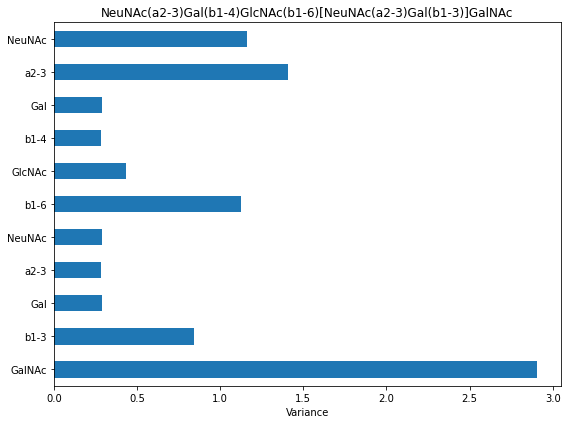

In [39]:
#example for how to use the glycan variance estimation function
pool_df, binar_df, unique_tokens, glycan = glycan_sensitivity(df_spec.target.values.tolist()[342],
                                            mode = 'extreme')
plt.figure(figsize = (8,6))
ax = binar_df.T.Variance.plot(kind = 'barh')
plt.yticks(range(len(pool_df.label.values.tolist()[0].split('*'))), pool_df.label.values.tolist()[0].split('*'))
plt.ylim(len(pool_df.label.values.tolist()[0].split('*')) - 0.5, -0.5)
plt.xlabel('Variance')
plt.title(glycan)
plt.tight_layout()

In [0]:
###LEGACY CODE for calculating GLYSUM, the glycoletter substitution matrix
###to initialize calculation, start with init_mat, then switch to out (second output of function) as new matrix input
###move glycolist one batch forward and repeat function run
###batches of 1000 glycans should take something like ~15-30 minutes each (don't remember exactly)

#all_idx = all_sugars + all_bonds
#init_mat = np.zeros((len(all_idx), len(all_idx)))
#df = pd.read_csv('data_files/new_unique_glycans.csv')
#df = isomorph_database(df)
#df = [item for sublist in df for item in sublist]
#glyco_list = df[:1000]
#n_out, out = eff_glycan_substitution_matrix(init_mat, glyco_list, mode = 'extreme')

In [0]:
###processing steps once you are finished with running through all glycans for calculating GLYSUM
###out here denotes the final output of the eff_glycan_substitution_matrix function
###replace 1238879 with total number of mutations (sum of n_out)

#token_pool = [item for sublist in df_all_long for item in sublist]
#token_baserate = Counter(token_pool)
#for key in token_baserate:
#    token_baserate[key] /= len(token_pool)

#df_sub = pd.DataFrame(out, index = all_idx, columns = all_idx)
#df_sub = (df_sub)/1238879
#for i in all_idx:
#  for j in all_idx:
#    df_sub.loc[i,j] = df_sub.loc[i,j] / (token_baserate[i] * token_baserate[j])
#scale = 4
#df_sub = (1/scale) * np.log(df_sub)
#df_sub = df_sub.replace(-np.Inf, -5)
#df_sub = round(df_sub)
#np.fill_diagonal(df_sub.values, 5)
#df_sub

# Biomining

In [0]:
df_spec = pd.read_csv('data_files/glyco_targets_species_seq_all_V2clean.csv')
df_spec.target = [str(k) for k in df_spec.target.values.tolist()]

#still missing: branches of branches
def link_find(s):
  """finds all disaccharide motifs in a glycan sequence using its isomorphs"""
  ss = find_isomorphs(s)
  coll = []
  for iso in ss:
    b_re = re.sub('\[[^\]]+\]', '', iso)
    for i in [iso, b_re]:
      b = i.split('(')
      b = [k.split(')') for k in b]
      b = [item for sublist in b for item in sublist]
      b = ['*'.join(b[i:i+3]) for i in range(0, len(b) - 2, 2)]
      b = [k for k in b if (re.search('\*\[', k) is None and re.search('\*\]\[', k) is None)]
      b = [k.strip('[') for k in b]
      b = [k.strip(']') for k in b]
      b = [k.replace('[', '') for k in b]
      b = [k.replace(']', '') for k in b]
      coll += b
  return list(set(coll))

#creating a links library of which motifs are present in which species
df_spec['links'] = [link_find(k) for k in df_spec.target.values.tolist()]
species_links = {k:list(set([item for sublist in df_spec[df_spec.species == k].links.values.tolist() for item in sublist])) for k in list(set(df_spec.species.values.tolist()))}
links_species = {}
for k,v in species_links.items():
    for x in v:
        links_species.setdefault(x,[]).append(k)

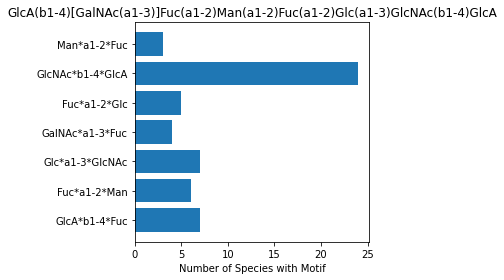

,Man*a1-2*Fuc,GlcNAc*b1-4*GlcA,Fuc*a1-2*Glc,GalNAc*a1-3*Fuc,Glc*a1-3*GlcNAc,Fuc*a1-2*Man,GlcA*b1-4*Fuc
0,Providencia_alcalifaciens,Pasteurella_multocida,Pleurotus_florida,Providencia_stuartii,Pectobacterium_atrosepticum,Azospirillum_fermentarium,Providencia_stuartii
1,Rhizobium_leguminosarum,Acinetobacter_calcoaceticus,Escherichia_coli,Escherichia_coli,Listeria_innocua,Bacillus_coagulans,Erwinia_tahitica
2,Providencia_rustigianii,Proteus_mirabilis,Providencia_alcalifaciens,Providencia_rustigianii,Escherichia_coli,Azohydromonas_lata,Acer_pseudoplatanus
3,NaN,Proteus_genomospecies,Providencia_rustigianii,Edwardsiella_tarda,Burkholderia_cepacia,Tremella_fuciformis,Escherichia_coli
4,NaN,Streptococcus_pyogenes,Tuber_rufum,NaN,Hafnia_alvei,Providencia_rustigianii,Providencia_alcalifaciens
5,NaN,Acinetobacter_baumannii,NaN,NaN,Listeria_ivanovii,Phellinus_igniarius,Pectinatus_frisingensis
6,NaN,Escherichia_coli,NaN,NaN,Providencia_rustigianii,NaN,Providencia_rustigianii
7,NaN,Providencia_alcalifaciens,NaN,NaN,NaN,NaN,NaN
8,NaN,Rhodococcus_erythropolis,NaN,NaN,NaN,NaN,NaN
9,NaN,Salmonella_sp,NaN,NaN,NaN,NaN,NaN


In [43]:
def biomine_links(glycan):
  """returns a dataframe of species capable of synthesizing each disaccharide motif of a glycan"""
  parts = link_find(glycan)
  part_dic = {k:pd.Series(links_species[k]) for k in parts}
  part_df = pd.DataFrame.from_dict(part_dic)
  plt.barh(range(len(part_dic)), [len(k) for k in part_dic.values()])
  plt.yticks(range(len(part_dic)), list(part_dic.keys()))
  plt.gca().invert_yaxis()
  plt.xlabel('Number of Species with Motif')
  plt.title(glycan)
  plt.tight_layout()
  plt.show()
  return part_df

#example
biomine_links(df_spec.target.values.tolist()[2172])

# Local Structural Context Analysis

In [0]:
def main_v_side_branch(sugar, glycan_list):
  """counts occurrence of glycoletter in main and side branches of glycans"""
  main = 0
  side = 0
  for k in range(len(glycan_list)):
    starts = [m.start() for m in re.finditer(sugar, glycan_list[k])]
    init = 0
    for i in starts:
      gly = glycan_list[k][init:i]
      if '[' in gly and ']' not in gly:
        side += 1
      else:
        main += 1
      init = i
  return main, side

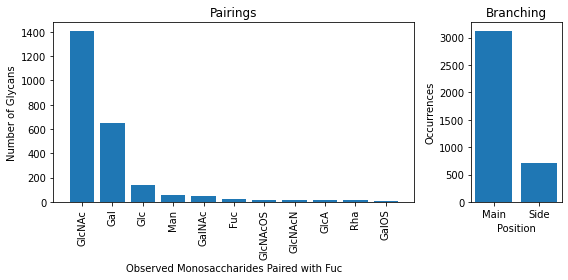

In [45]:
def characterize_monosaccharide(sugar, mode = 'bond'):
  """for a given monosaccharide/bond, return typical neighboring bond/monosaccharide and preference for main vs. side branch in glycan"""
  pool = [link_find(k) for k in df_spec.target.values.tolist()]
  pool = [item for sublist in pool for item in sublist]

  if mode == 'bond':
    pool = [k.split('*')[0] for k in pool if k.split('*')[1] == sugar]
    lab = 'Observed Monosaccharides Making Bond %s' % sugar
  elif mode == 'sugar':
    pool = [k.split('*')[2] for k in pool if k.split('*')[0] == sugar]
    lab = 'Observed Monosaccharides Paired with %s' % sugar
  elif mode == 'sugarbond':
    pool = [k.split('*')[1] for k in pool if k.split('*')[0] == sugar]
    lab = 'Observed Bonds Made by %s' % sugar
    
  cou = Counter(pool).most_common()
  cou_k = [k[0] for k in cou if k[1] > 10]
  cou_v = [k[1] for k in cou if k[1] > 10]

  main, side = main_v_side_branch(sugar, df_spec.target.values.tolist())

  fig, (a0,a1) = plt.subplots(1, 2 , figsize = (8, 4), gridspec_kw = {'width_ratios': [4, 1]})
  a0.bar(cou_k, cou_v)
  a0.set_ylabel('Number of Glycans')
  a0.set_xlabel(lab)
  a0.set_title('Pairings')
  if mode == 'sugar' or mode == 'bond':
    #a0.set_xticks(rotation='vertical')
    plt.setp(a0.get_xticklabels(), rotation='vertical')
  
  a1.bar(['Main', 'Side'], [main, side])
  a1.set_ylabel('Occurrences')
  a1.set_xlabel('Position')
  a1.set_title('Branching')

  fig.tight_layout()
  fig.show()

#example
characterize_monosaccharide('Fuc', mode = 'sugar')

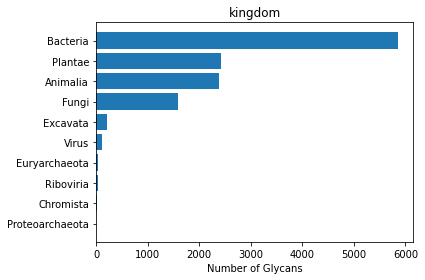

In [46]:
#get frequency distribution of taxonomic groups in glycan dataset
rank = 'kingdom'
cts = df_spec[rank].value_counts()[:10]
names = df_spec[rank].value_counts().index.tolist()[:10]
plt.barh(range(len(cts)), cts)
plt.yticks(range(len(cts)), names)
plt.gca().invert_yaxis()
plt.xlabel('Number of Glycans')
plt.title(rank)
plt.tight_layout()
plt.show()

# SweetOrigins - Species Classifier

In [0]:
df_spec = pd.read_csv('data_files/glyco_targets_species_seq_all_V2clean.csv')
df_spec.domain = [k.strip() for k in df_spec.domain.values.tolist()]
df_spec.kingdom = [k.strip() for k in df_spec.kingdom.values.tolist()]
df_spec.phylum = [k.strip() for k in df_spec.phylum.values.tolist()]
df_spec['class'] = [k.strip() for k in df_spec['class'].values.tolist()]
df_spec.order = [k.strip() for k in df_spec.order.values.tolist()]
df_spec.family = [k.strip() for k in df_spec.family.values.tolist()]
df_spec.genus = [k.strip() for k in df_spec.genus.values.tolist()]
df_spec.target = [str(k) for k in df_spec.target.values.tolist()]

#for non-isomorph
#df_spec.target = process_glycans(df_spec.target.values.tolist())

#for isomorph
df_spec.target = isomorph_database(df_spec)
df_spec.target = [process_glycans(k) for k in df_spec.target.values.tolist()]
df_spec.iloc[:,1:] = df_spec.iloc[:,1:].apply(lambda x: x.str.strip())

lib = [item for sublist in df_spec.target.values.tolist() for item in sublist]

#outcomment below for non-isomorph
lib = [item for sublist in lib for item in sublist]
lib = list(sorted(list(set(tuple(i) for i in lib))))
lib = [list(k) for k in lib]
lib_size = len(lib)

In [0]:
#for non-isomorph
#coded_glycans = [string_to_labels(k, lib) for k in df_spec.target.values.tolist()]
coded_glycans = [[string_to_labels(k, lib) for k in j] for j in df_spec.target.values.tolist()]

df_spec['seq_coded'] = coded_glycans

In [0]:
#best function ever
def hierarchy_filter(df_in, rank = 'domain', min_seq = 5, isomorphed = True):
  """splits data in train/test at the taxonomic level, removing duplicate glycans and infrequent classes"""
  df = copy.deepcopy(df_in)
  rank_list = ['target','species','genus','family','order','class','phylum','kingdom','domain']
  rank_list.remove(rank)
  df.drop(rank_list, axis = 1, inplace = True)
  class_list = list(set(df[rank].values.tolist()))
  temp = []

  for i in range(len(class_list)):
    t = df[df[rank] == class_list[i]]
    t['seq_coded_t'] = t['seq_coded'].values.tolist()
    if isomorphed:
      t['seq_coded_t'] = t['seq_coded_t'].apply(lambda x: x[0])
    t['seq_coded_t'] = t['seq_coded_t'].apply(lambda x: tuple(x))
    t = t.drop_duplicates('seq_coded_t', keep = 'first')
    temp.append(t)
  df = pd.concat(temp).reset_index(drop = True)

  counts = df[rank].value_counts()
  allowed_classes = [counts.index.tolist()[k] for k in range(len(counts.index.tolist())) if (counts >= min_seq).values.tolist()[k]]
  df = df[df[rank].isin(allowed_classes)]

  class_list = list(sorted(list(set(df[rank].values.tolist()))))
  class_converter = {class_list[k]:k for k in range(len(class_list))}
  df[rank] = [class_converter[k] for k in df[rank].values.tolist()]

  sss = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2)
  sss.get_n_splits(df.seq_coded.values.tolist(), df[rank].values.tolist())
  for i, j in sss.split(df.seq_coded.values.tolist(), df[rank].values.tolist()):
    train_x = [df.seq_coded.values.tolist()[k] for k in i]
    len_train_x = [len(k) for k in train_x]
    if isomorphed:
      train_x = [item for sublist in train_x for item in sublist]

    val_x = [df.seq_coded.values.tolist()[k] for k in j]
    id_val = list(range(len(val_x)))
    len_val_x = [len(k) for k in val_x]
    if isomorphed:
      val_x = [item for sublist in val_x for item in sublist]

    train_y = [df[rank].values.tolist()[k] for k in i]
    if isomorphed:
      train_y = [[train_y[k]] * len_train_x[k] for k in range(len(len_train_x))]
      train_y = [item for sublist in train_y for item in sublist]

    val_y = [df[rank].values.tolist()[k] for k in j]
    if isomorphed:
      val_y = [[val_y[k]] * len_val_x[k] for k in range(len(len_val_x))]
      val_y = [item for sublist in val_y for item in sublist]
    id_val = [[id_val[k]] * len_val_x[k] for k in range(len(len_val_x))]
    id_val = [item for sublist in id_val for item in sublist]

  return train_x, val_x, train_y, val_y, id_val, class_list, class_converter

In [50]:
#dataset class for multiclass SweetOrigins classifiers
class SugarClassDataset(data.Dataset):
  def __init__(self, df, y, mode):
    self.df = df
    self.y = y
    self.max_len = len(max(self.df, key = len))
    self.idx = range(len(self.df))
    self.mode = mode
    
  def __len__(self):
    return len(self.idx)
  
  def __getitem__(self,index):
    index = self.idx[index]
    raw_string = self.df[index]
    labels = self.y[index]
    seq_length = len(raw_string)
    string_labels_padded = pad_sequence(raw_string, max_length = self.max_len, pad_label = lib_size)
    
    return (torch.LongTensor(string_labels_padded),
           torch.LongTensor([labels]),
           torch.LongTensor([seq_length]))
  
def post_process_sequence_batch(batch_tuple):
    input_seq, output_seq, seq_length = batch_tuple
    split_input_seq_batch = input_seq.split(split_size = 1)
    split_output_seq_batch = output_seq.split(split_size = 1)
    split_length_batch = seq_length.split(split_size = 1)
    
    train_data_tuples = zip(split_input_seq_batch,
                         split_output_seq_batch,
                         split_length_batch)
    sorted_train_data = sorted(train_data_tuples,
                            key = lambda p:int(p[2]),
                            reverse = True)
    split_input_batch, split_output_batch, split_length_batch = zip(*sorted_train_data)
    input_seq_sorted = torch.cat(split_input_batch)
    output_seq_sorted = torch.cat(split_output_batch)
    length_sorted = torch.cat(split_length_batch)
    
    input_seq_sorted = input_seq_sorted[:,:length_sorted[0,0]]
    output_seq_sorted = output_seq_sorted[:,:length_sorted[0,0]]
    
    input_seq_transposed = input_seq_sorted.transpose(0,1)
    
    length_sorted_list = list(length_sorted)
    length_sorted_list = list(map(lambda x: int(x), length_sorted_list))
    
    return input_seq_transposed, output_seq_sorted, length_sorted_list

#processing dataset at the class level as an example
train_x, val_x, train_y, val_y, id_val, class_list, class_converter = hierarchy_filter(df_spec, rank = 'class',isomorphed = True)

trainset = SugarClassDataset(train_x, train_y, 'train')
trainset_loader = data.DataLoader(trainset, batch_size = 32,
                               shuffle = True, num_workers = 4)

valset = SugarClassDataset(val_x, val_y, 'val')
valset_loader = data.DataLoader(valset, batch_size = 32,
                             shuffle = False)

dataloaders = {'train':trainset_loader, 'val':valset_loader}
dataset_sizes = {'train':len(train_x), 'val':len(val_y)}

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

In [0]:
#defining SweetOrigins model class, can be used flexibly across taxonomic levels
class linkRNN(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes, n_layers = 3):
    super(linkRNN, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.num_classes = num_classes
    self.n_layers = n_layers
    
    self.encoder = nn.Embedding(input_size, hidden_size, padding_idx = lib_size)
    self.decoder = nn.Linear(hidden_size, num_classes)
    self.gru = nn.LSTM(hidden_size, hidden_size, n_layers, bidirectional = True)
    self.logits_fc = nn.Linear(2*hidden_size, num_classes)
    
  def forward(self, input_seq, input_seq_len, hidden = None):
    batch_size = input_seq.shape[1]
    self.bn1 = nn.BatchNorm1d(batch_size).cuda()
    embedded = self.bn1(self.encoder(input_seq))
    
    packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, input_seq_len, enforce_sorted = False)
    outputs, (h_n, c_n)=self.gru(packed, hidden)
    outputs, outputs_len = torch.nn.utils.rnn.pad_packed_sequence(outputs)

    ## last forward hidden state
    h_n_a = h_n[2,:,:]
    ## last backward hidden state
    h_n_b = h_n[3,:,:]
    h_n = torch.cat((h_n_a, h_n_b), 1)
    
    logits = self.logits_fc(h_n)
    
    return logits, hidden

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs = 25):
  """training loop for SweetOrigins classifiers"""
  since = time.time()
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  val_losses = []
  val_acc = []

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-'*10)
    
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()
        
      running_loss = []
      running_acc = []
      running_mcc = []
      actuals = []
      predictions = []
      for batch in dataloaders[phase]:
        post_processed_batch_tuple = post_process_sequence_batch(batch)
        inputs, outputs, lengths = post_processed_batch_tuple
        inputs = inputs.cuda()
        outputs = outputs.cuda()
        optimizer.zero_grad()
        
        with torch.set_grad_enabled(phase == 'train'):
          pred,_ = model(inputs, lengths)
          pred_arg = np.argmax(pred.detach().cpu().numpy(), axis = 1)
          predictions += pred_arg.tolist()
          actuals += outputs.detach().cpu().numpy().tolist()
          loss = criterion(pred, outputs.squeeze(1))
          if phase == 'train':
            loss.backward()
            optimizer.step()
            
        running_loss.append(loss.item())
        running_acc.append(accuracy_score(pred_arg, outputs.detach().cpu().numpy()))
        running_mcc.append(matthews_corrcoef(outputs.detach().cpu().numpy(), pred_arg))
        
      epoch_loss = np.mean(running_loss)
      epoch_acc = np.mean(running_acc)
      epoch_mcc = np.mean(running_mcc)
      print('{} Loss: {:.4f} Accuracy: {:.4f} MCC: {:.4f}'.format(
          phase, epoch_loss, epoch_acc, epoch_mcc))
      
      cm = confusion_matrix(actuals, predictions)
      fig, ax = plt.subplots()
      im = ax.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Blues)
      ax.figure.colorbar(im, ax = ax)
      ax.set(xticks = np.arange(cm.shape[1]),
           yticks = np.arange(cm.shape[0]),
           xticklabels = list(class_converter.keys()), yticklabels = (class_converter.keys()),
           title = phase,
           ylabel = 'True label',
           xlabel = 'Predicted label')
      plt.setp(ax.get_xticklabels(), rotation = 45, ha = "right",
             rotation_mode = "anchor")
      ax.set_ylim(len(list(class_converter.keys())) - 0.5, -0.5)
      fig.tight_layout()
      plt.show()
      
      if phase == 'val' and epoch_acc >= best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
      if phase == 'val':
        val_losses.append(epoch_loss)
        val_acc.append(epoch_acc)
        early_stopping(epoch_loss, model)

      scheduler.step()
        
    if early_stopping.early_stop:
      print("Early stopping")
      break
    print()
    
  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(
      time_elapsed // 60, time_elapsed % 60))
  print('Best val Accuracy: {:4f}'.format(best_acc))
  model.load_state_dict(best_model_wts)

  ## plot loss & acc over the course of training 
  fig, ax = plt.subplots(nrows = 2, ncols = 1) 
  plt.subplot(2, 1, 1)
  plt.plot(range(epoch+1), val_losses)
  plt.title('Training of SweetTalk')
  plt.ylabel('Validation Loss')
  plt.legend(['Validation Loss'], loc = 'best')

  plt.subplot(2, 1, 2)
  plt.plot(range(epoch+1), val_acc)
  plt.ylabel('Validation Accuracy')
  plt.xlabel('Number of Epochs')
  plt.legend(['Validation Accuracy'], loc = 'best')
  return model

In [53]:
###generating an initial embedding layer for SweetOrigins based on SweetTalk

#generate glycoletter token labels for relevant glycowords
words = list(sorted(list(set([tuple(string_to_labels(k, lib_all_long)) for k in lib]))))
words_label = list(sorted(list(set([tuple(k) for k in lib]))))

#construct relevant glycoword embeddings from their glycoletter embeddings
rep = {}
for k in range(len(lib)):
  rep[words_label[k]] = np.mean(embed[list(words[k]), :], axis = 0)

#add a padding embedding to construct initial embedding layer values
init_emb = np.array(list(rep.values()))
init_emb = np.concatenate([init_emb, np.array([0]*128).reshape(1,-1)])
init_emb.shape

(13644, 128)

In [54]:
model2 = linkRNN(input_size = lib_size + 1, hidden_size = 128,
                       num_classes = len(class_list))                       
model2.apply(init_weights)
model2.encoder.weight.data = torch.from_numpy(init_emb).float()
model2.cuda()

early_stopping = EarlyStopping(patience = 10, verbose = True)
optimizer_ft = optim.Adam(model2.parameters(), lr = 0.0001, weight_decay = 5e-3)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer_ft, 100)
criterion = nn.CrossEntropyLoss().cuda()
#model_ft2 = train_model(model2, criterion, optimizer_ft, scheduler,
#                    num_epochs = 100)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
#loading trained models
model_species = torch.load('models/SweetTalk_large_exp_species_iso2.pt').eval()
model_genus = torch.load('models/SweetTalk_large_exp_genus_iso2.pt').eval()
model_family = torch.load('models/SweetTalk_large_exp_family_iso2.pt').eval()
model_order = torch.load('models/SweetTalk_large_exp_order_iso2.pt').eval()
model_class = torch.load('models/SweetTalk_large_exp_class_iso2.pt').eval()
model_phylum = torch.load('models/SweetTalk_large_exp_phylum_iso2.pt').eval()
model_kingdom = torch.load('models/SweetTalk_large_exp_kingdom_iso2.pt').eval()
model_domain = torch.load('models/SweetTalk_large_exp_domain_iso2.pt').eval()
embed2 = model_species.encoder.weight.data.cpu().numpy()

# Making Dendrograms from Distance Matrices

In [0]:
#example
df_dist = pd.read_csv('data_files/averaged_bacilli_dist.csv')
df_dist.fillna(0, inplace = True)
df_dist.columns = [re.sub('[^a-zA-Z0-9 \n\.]', '_', k) for k in df_dist.columns.values.tolist()]

In [0]:
#outcomment for switching to neighbor joining; print Z for Newick tree in case of neighbor joining
Z = linkage(df_dist)
#Z = nj(DistanceMatrix(df_dist.values, df_dist.columns.values.tolist()), result_constructor = str)
plt.figure(figsize = (10,10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Distance')
plt.ylabel('Bacilli')
dendrogram(
    Z,
    truncate_mode = 'lastp',  # show only the last p merged clusters
    orientation = 'left',
    p = 300,  # show only the last p merged clusters
    show_leaf_counts = False,  # otherwise numbers in brackets are counts
    leaf_rotation = 0.,
    labels = df_dist.columns.values.tolist(),
    leaf_font_size = 11.,
    show_contracted = True,  # to get a distribution impression in truncated branches
)

In [0]:
def getNewick(node, newick, parentdist, leaf_names):
  """converts linkage dendrogram into Newick tree"""
  if node.is_leaf():
    return "%s:%.2f%s" % (leaf_names[node.id], parentdist - node.dist, newick)
  else:
    if len(newick) > 0:
      newick = "):%.2f%s" % (parentdist - node.dist, newick)
    else:
      newick = ");"
    newick = getNewick(node.get_left(), newick, node.dist, leaf_names)
    newick = getNewick(node.get_right(), ",%s" % (newick), node.dist, leaf_names)
    newick = "(%s" % (newick)
    return newick

tree = hierarchy.to_tree(Z, False)
getNewick(tree, "", tree.dist, df_dist.columns.values.tolist())

# Inferring Taxonomic Origin of Glycans

In [0]:
#recalculate glycoword embeddings from SweetTalk
word_lib = list(set([tuple(k) for k in df_all_long]))
word_lib = [list(k) for k in word_lib]

words_full = list(sorted(list(set([tuple(string_to_labels(k, lib_all_long)) for k in df_all_long]))))
words_label_full = list(sorted(list(set([tuple(k) for k in df_all_long]))))

rep_full = {}
for k in range(len(words_full)):
  rep_full[words_label_full[k]] = np.mean(embed[list(words_full[k]), :], axis = 0)

df_spec2 = pd.read_csv('data_files/glyco_targets_species_seq_all_V2clean.csv')
df_spec2.domain = [k.strip() for k in df_spec2.domain.values.tolist()]
df_spec2.kingdom = [k.strip() for k in df_spec2.kingdom.values.tolist()]
df_spec2.phylum = [k.strip() for k in df_spec2.phylum.values.tolist()]
df_spec2['class'] = [k.strip() for k in df_spec2['class'].values.tolist()]
df_spec2.order = [k.strip() for k in df_spec2.order.values.tolist()]
df_spec2.family = [k.strip() for k in df_spec2.family.values.tolist()]
df_spec2.genus = [k.strip() for k in df_spec2.genus.values.tolist()]
df_spec2.target = [str(k) for k in df_spec2.target.values.tolist()]
df_spec2.target = [small_motif_find(k) for k in df_spec2.target.values.tolist()]

glycobase = pd.read_csv('data_files/glycobase.csv')
unk = glycobase[glycobase.species.isna()].glycan.values.tolist()
models = [model_domain, model_kingdom, model_phylum, model_class, model_order, model_family, model_genus, model_species]
knowns = glycobase[~glycobase.species.isna()]
knowns.glycan = [small_motif_find(k) for k in knowns.glycan.values.tolist()]
knowns.species = knowns.species.apply(lambda x: ast.literal_eval(x))
knowns.reset_index(drop = True, inplace = True)
knowns

In [0]:
def speciesPairwiseAlign(query, corpus, n = 5, database = df_spec2, vocab = (all_sugars + all_bonds),
                  submat = df_sub4, mismatch = -10, gap = -5):
  """function to get the species labels of glycans with the n best alignments to target glycan"""
  if n == 0:
    n = len(corpus)
  a = Sequence(query.split('*'))
  v = Vocabulary()
  voc = v.encodeSequence(Sequence(vocab))
  a_enc = v.encodeSequence(a)
  scoring = SubstitutionScoring(submat, mismatch)
  aligner = GlobalSequenceAligner(scoring, gap)
  species_list = []
  full_species_list = database.species.values.tolist()
  seqs = database.glycan.values.tolist()
  b_full = [v.encodeSequence(Sequence(seqs[corpus[k]].split('*'))) for k in range(len(corpus))]
  track = [(aligner.align(a_enc, b_full[k], backtrace = False), full_species_list[corpus[k]]) for k in range(len(b_full))]

  track.sort(key = operator.itemgetter(0), reverse = True)
  for k in track[:n]:
    score, species = k
    species_list.append(species)
  return species_list

class UnlabeledTensorDataset(data.TensorDataset):
    """Dataset wrapping unlabeled data tensors.

    Each sample will be retrieved by indexing tensors along the first
    dimension.

    Arguments:
        data_tensor (Tensor): contains sample data.
    """
    def __init__(self, data_tensor):
        self.df = data_tensor
        self.max_len = len(max(self.df, key = len))
        self.idx = range(len(self.df))

    def __getitem__(self, index):
        index = self.idx[index]
        raw_string = self.df[index]
        seq_length = len(raw_string)
        string_labels_padded = pad_sequence(raw_string, max_length = self.max_len, pad_label = lib_size)
        return (torch.LongTensor(string_labels_padded),
                torch.LongTensor([seq_length]))
    
    def __len__(self):
        return len(self.df)

def string_to_labels_flex(seq, libr):
  """constructs list of tokenized glycowords for glycan, either from library or by finding closest observed glycowords"""
  out = []
  for i in range(len(seq)):
    if seq[i] in libr:
      out.append(character_to_label(seq[i], libr))
    else:
      temp = rep_full[tuple(seq[i])]
      temp_cos = cosine_similarity(temp.reshape(1,-1), init_emb).tolist()
      temp_cos = lib[np.argmax(temp_cos)]
      out.append(character_to_label(temp_cos, libr))
  return out

def generate_class_converters(df_in, rank_set = ['domain', 'kingdom', 'phylum', 'class',
                                                 'order', 'family', 'genus', 'species']):
  """generates dictionaries mapping taxonomic groups to labels"""
  class_converter_zoo = []
  for rank in rank_set:
    df = copy.deepcopy(df_in)
    rank_list = ['target', 'species', 'genus', 'family',
                 'order', 'class', 'phylum', 'kingdom', 'domain']
    rank_list.remove(rank)
    df.drop(rank_list, axis = 1, inplace = True)
    class_list_temp = list(sorted(list(set(df[rank].values.tolist()))))
    temp = []

    for i in range(len(class_list_temp)):
      t = df[df[rank] == class_list_temp[i]]
      t['seq_coded_t'] = t['seq_coded'].values.tolist()
      t['seq_coded_t'] = t['seq_coded_t'].apply(lambda x: x[0])
      t['seq_coded_t'] = t['seq_coded_t'].apply(lambda x: tuple(x))
      t = t.drop_duplicates('seq_coded_t', keep = 'first')
      temp.append(t)

    df = pd.concat(temp).reset_index(drop = True)
    counts = df[rank].value_counts()
    allowed_classes = [counts.index.tolist()[k] for k in range(len(counts.index.tolist())) if (counts >= 5).values.tolist()[k]]
    df = df[df[rank].isin(allowed_classes)]
    class_converter_zoo.append({class_list_temp[k]:k for k in range(len(class_list_temp))})
  return class_converter_zoo

def get_evo_info(species_list):
  """for each species in a list, get all the taxonomic information"""
  info = []
  for k in range(len(species_list)):
    if isinstance(species_list[k], list):
      for j in range(len(species_list[k])):
        temp = species_list[k][j].strip()
        idx = df_spec.species.values.tolist().index(temp)
        info = info + df_spec.iloc[idx, 1:9].values.tolist()
    else:
      temp = species_list[k].strip()
      idx = df_spec.species.values.tolist().index(temp)
      info = info + df_spec.iloc[idx, 1:9].values.tolist()
  return info

def evo_predict(glycan_list, model_zoo, rank_set = ['domain', 'kingdom', 'phylum', 'class',
                                                    'order', 'family', 'genus', 'species'],
                class_converter_zoo = None):
  """wrapper function to return the congruent taxonomic prediction of SweetOrigins and glycan alignments"""
  if class_converter_zoo is None:
    class_converter_zoo = generate_class_converters(df_spec, rank_set = rank_set)
  proc_glycan = process_glycans(glycan_list)
  coded_glycan = [string_to_labels_flex(k, lib) for k in proc_glycan]
  data_t = UnlabeledTensorDataset(coded_glycan)
  data_loader = data.DataLoader(data_t, batch_size = len(coded_glycan), shuffle = False, num_workers = 4, pin_memory = True)
  inputs, lengths = next(iter(data_loader))
  inputs = inputs.transpose(0,1).cuda()
  lengths = lengths.cpu().squeeze()
  out = []

  for model, class_converter in list(zip(model_zoo, class_converter_zoo)):
    temp, _ = model(inputs, lengths)
    pred_arg = np.argmax(temp.detach().cpu().numpy(), axis = 1)
    out.append([list(class_converter.keys())[list(class_converter.values()).index(k)] for k in pred_arg])

  align_glycan = [small_motif_find(k) for k in glycan_list]
  align_species = [speciesPairwiseAlign(k, list(range(len(knowns))), database = knowns) for k in align_glycan]
  align_species = [get_evo_info(k) for k in align_species]

  out2 = []
  for j in out:
    out2.append([j[k] if j[k] in align_species[k] else 'none' for k in range(len(j))])

  out3 = []
  out2 = list(zip(out2[0], out2[1], out2[2], out2[3], out2[4], out2[5], out2[6], out2[7]))
  for k in range(len(out2)):
    fil = [out2[k][i] != 'none' for i in range(len(out2[k]))]
    temp = list(compress(list(out2[k]), fil))
    if len(temp) > 0:
      out3.append(temp[-1])
    else:
      out3.append('none')
  return out3

In [0]:
class_converters = generate_class_converters(df_spec,
                                             rank_set = ['domain', 'kingdom', 'phylum', 'class',
                                                         'order', 'family', 'genus', 'species'])

In [0]:
###LEGACY CODE to predict taxonomic origin of unlabeled glycans
###batches of 100 glycans took about one hour

#swath = 0
#glycs = unk[swath:swath+100]
#preds = evo_predict(glycs, models, class_converter_zoo = class_converters)
#out = pd.DataFrame(list(zip(glycs,preds)), columns = ['glycan', 'inferred_species'])
#out.to_csv('inferred_species_'+str(swath)+':'+str(swath+100)+'.csv', index = False)

# Analyzing Embedding Changes in Different SweetOrigins Models

In [0]:
embed_genus = model_genus.encoder.weight.data.cpu().numpy()
embed_family = model_family.encoder.weight.data.cpu().numpy()
embed_order = model_order.encoder.weight.data.cpu().numpy()
embed_class = model_class.encoder.weight.data.cpu().numpy()
embed_phylum = model_phylum.encoder.weight.data.cpu().numpy()
embed_kingdom = model_kingdom.encoder.weight.data.cpu().numpy()
embed_domain = model_domain.encoder.weight.data.cpu().numpy()

#get glycan embeddings on all taxonomic levels
knowns2 = glycobase[~glycobase.species.isna()]
knowns3 = process_glycans(knowns2.glycan.values.tolist())
coded_glycans = [string_to_labels_flex(k, lib) for k in knowns3]
coded_glycans_id = knowns2.glycan_id.values.tolist()
out_species = [np.mean(embed2[k,:], axis = 0) for k in coded_glycans]
out_genus = [np.mean(embed_genus[k,:], axis = 0) for k in coded_glycans]
out_family = [np.mean(embed_family[k,:], axis = 0) for k in coded_glycans]
out_order = [np.mean(embed_order[k,:], axis = 0) for k in coded_glycans]
out_class = [np.mean(embed_class[k,:], axis = 0) for k in coded_glycans]
out_phylum = [np.mean(embed_phylum[k,:], axis = 0) for k in coded_glycans]
out_kingdom = [np.mean(embed_kingdom[k,:], axis = 0) for k in coded_glycans]
out_domain = [np.mean(embed_domain[k,:], axis = 0) for k in coded_glycans]

In [0]:
#get embedding changes between two taxonomic levels
domain_kingdom = [np.linalg.norm(i - j) for i, j in list(zip(out_domain, out_kingdom))]
kingdom_phylum = [np.linalg.norm(i - j) for i, j in list(zip(out_kingdom, out_phylum))]
phylum_class = [np.linalg.norm(i - j) for i, j in list(zip(out_phylum, out_class))]
class_order = [np.linalg.norm(i - j) for i, j in list(zip(out_class, out_order))]
order_family = [np.linalg.norm(i - j) for i, j in list(zip(out_order, out_family))]
family_genus = [np.linalg.norm(i - j) for i,j in list(zip(out_family, out_genus))]
genus_species = [np.linalg.norm(i - j) for i, j in list(zip(out_genus, out_species))]

In [0]:
#convert into dataframe and visualize as ridgeline plot
diff_df = pd.DataFrame(list(zip(domain_kingdom, kingdom_phylum, phylum_class, class_order,
                                order_family, family_genus, genus_species)),
                       columns = ['domain_kingdom', 'kingdom_phylum', 'phylum_class',
                                'class_order', 'order_family', 'family_genus', 'genus_species'])
diff_df['glycan_id'] = coded_glycans_id
fig, axes = joypy.joyplot(diff_df.iloc[:,:-1])

In [0]:
#plot embedding changes between taxonomic levels as a function of glycan length; change diff_df columns for different comparisons
len_glyco = [len(k.split('*')) for k in knowns.glycan.values.tolist()]
sns.regplot(len_glyco, diff_df.iloc[:,0])
plt.xlabel('Glycan Length')
plt.ylabel('Embedding Distance')
plt.title('Domain to Kingdom')

# Evolutionary Tracking of Glycan Motifs

In [0]:
seq_species = [np.mean(embed_phylum[k[0],:], axis = 0) for k in df_spec.seq_coded.values.tolist()]

In [0]:
#reducer_all = umap.UMAP(random_state = 0, transform_seed = 0)
#dim_red_emb_all = reducer_all.fit_transform(pd.DataFrame(seq_species))
#tsne_emb_all = TSNE(random_state = 42).fit_transform(pd.DataFrame(seq_species))
with open('data_files/kingdom_phylum_embedding.pkl', 'rb') as file:
  tsne_emb_all = pickle.load(file)

In [0]:
def link_species_filter(link, rank):
  """returns taxonomic groups containing a given glycan motif and mask to highlight glycans in evolutionary embedding plot"""
  rel_species = links_species[link]
  rel_rank = df_spec[df_spec.species.isin(rel_species)]
  rel_rank = list(set(rel_rank[rank].values.tolist()))
  print(rel_rank)
  rank_mask = ['darkorange' if link in df_spec2['target'].values.tolist()[k]
                else 'cornflowerblue' for k in range(len(df_spec2['target'].values.tolist()))]
  return rank_mask

#example
link_labels = link_species_filter('Fuc*a1-2*Gal', 'phylum')

In [0]:
#plots evolutionary glycan embeddings highlighted by taxonomic level or tracked glycan motif
rank = 'kingdom'
rank_converter = ['domain', 'kingdom', 'phylum', 'class',
                  'order', 'family', 'genus', 'species']
rank_number = rank_converter.index(rank)

plt.figure(figsize = (12,8))
branch = 'spec'

if branch == 'spec':
  ax = plt.scatter(tsne_emb_all[:,0], tsne_emb_all[:,1], s = 50, c = color_labels, cmap = 'Set3', alpha = 0.1,
                   rasterized = True)
  leg = plt.legend(handles = ax.legend_elements()[0], labels = list(class_converters[rank_number].keys()),
                   bbox_to_anchor = (1.05, 1), loc = 2, borderaxespad = 0.)
  for lh in leg.legendHandles: 
      lh._legmarker.set_alpha(1)
elif branch == 'link':
  ax = plt.scatter(tsne_emb_all[:,0], tsne_emb_all[:,1], s = 50, c = link_labels, alpha = 0.1, rasterized = True)
  leg = plt.legend(handles = ax.legend_elements()[0], labels = ['-', 'Fuc*a1-2*Gal'])
  for lh in leg.legendHandles: 
      lh._legmarker.set_alpha(1)

loopie = list(set(df_spec['phylum'].values.tolist()))
for i, txt in enumerate(loopie):
  idx = df_spec['phylum'].values.tolist().index(txt)
  text = plt.annotate(txt, (tsne_emb_all[:,0][idx], tsne_emb_all[:,1][idx]))
  text.set_path_effects([path_effects.Stroke(linewidth = 3, foreground = 'white'),
                       path_effects.Normal()])
  
plt.xlabel('Dim 1')
plt.ylabel('Dim 2')
plt.tight_layout()

# Code for Generating the Viral Glycan Plots

In [0]:
matplotlib.rcParams.update({'errorbar.capsize': 6})

def findClosest(query, corpus, n = 1, vocab = (all_sugars+all_bonds),
                  submat = df_sub4, mismatch = -10, gap = -5):
  """just outputs the sequences of the n glycans with the best alignments to input glycan"""
  if n == 0:
    n = len(corpus)
  a = Sequence(query.split('*'))
  v = Vocabulary()
  voc = v.encodeSequence(Sequence(vocab))
  a_enc = v.encodeSequence(a)
  scoring = SubstitutionScoring(submat, mismatch)
  aligner = GlobalSequenceAligner(scoring, gap)
  seq_list = []
  b_full = [v.encodeSequence(Sequence(corpus[k].split('*'))) for k in range(len(corpus))]
  track = [(aligner.align(a_enc, b_full[k], backtrace = False), corpus[k]) for k in range(len(b_full))]

  track.sort(key = operator.itemgetter(0), reverse = True)
  for k in track[:n]:
    score, seq = k
    seq_list.append(seq)
  return seq_list

def pairwise_vs_average_embedding(predator, prey, embed = embed2, name = None):
  """compares embedding distances between pairwise aligned and total averaged glycans of two groups"""
  pred_glycan = df_spec2[df_spec2.species == predator].target.values.tolist()
  prey_glycan = df_spec2[df_spec2.species == prey].target.values.tolist()
  pairwise_dist = []

  for k in pred_glycan:
    k2 = findClosest(k, prey_glycan)
    k_emb = seq2emb([k], embed = embed)[0]
    k2_emb = seq2emb(k2, embed = embed)[0]
    pairwise_dist.append(np.linalg.norm(k_emb - k2_emb))

  pred_emb = seq2emb(pred_glycan, embed = embed)
  prey_emb = seq2emb(prey_glycan, embed = embed)
  global_dist = np.linalg.norm(np.mean(pred_emb, axis = 0) - np.mean(prey_emb, axis = 0))

  plt.figure(figsize = (4, 6))
  plt.bar(range(2), [np.mean(pairwise_dist), global_dist], yerr = [scipy.stats.sem(pairwise_dist), 0])
  plt.xticks(range(2), ['Pairwise', 'Global'])
  plt.xlabel('Comparison Method')
  plt.ylabel('Euclidean Embedding Distance')
  plt.title(predator + ' vs ' + prey)
  plt.tight_layout()
  if name is None:
    plt.show()
  else:
    plt.savefig('embedding_distance_' + name + '.svg', format = 'svg', dpi = 300)
    plt.show()

#example
pairwise_vs_average_embedding('HumanImmunoDeficiency_Virus', 'Homo_sapiens')

# Generating a Distance Matrix from Glycan Embeddings

In [0]:
#get relevant glycans and labels for taxonomic group of interest
bacilli = df_spec[df_spec['class'] == 'Bacilli']
bacilli_min = list(sorted([(bacilli.species.value_counts() >= 5).index.tolist()[k]
                           for k in range(len((bacilli.species.value_counts() >= 5).index.tolist()))
                           if (bacilli.species.value_counts() >= 5).values.tolist()[k]]))
bacilli = bacilli[bacilli.species.isin(bacilli_min)]

rank = 'species'
bacilli_embed = [np.mean(embed2[k[0],:], axis = 0) for k in bacilli.seq_coded.values.tolist()]
bacilli_list = df_spec[df_spec['class'] == 'Bacilli'][rank].values.tolist()
class_list2 = list(sorted(list(set(df_spec[df_spec['class'] == 'Bacilli'][rank].values.tolist()))))

#construct average embedding per species (by averaging their glycan embeddings)
avgs = [np.mean([bacilli_embed[k] for k in range(len(bacilli_embed)) if
                 bacilli_list[k] == bacilli_min[i]], axis = 0) for i in range(len(bacilli_min))]

#calculate cosine distance matrix
dm = np.zeros((len(avgs), len(avgs)))
dm = pd.DataFrame(dm, columns = bacilli_min)
for i in range(len(avgs)):
  for j in range(len(avgs)):
    dm.iloc[i,j] = cosine(avgs[i], avgs[j])

# Working with E. coli Strain Glycans

In [0]:
strain_df = pd.read_csv('data_files/ecoli_strains.csv')
strain_df.target = process_glycans(strain_df.target.values.tolist())
strain_df['seq_coded'] = [string_to_labels_flex(k, lib) for k in strain_df.target.values.tolist()]
strain_df

In [0]:
strain_embed = [np.mean(embed2[k,:], axis = 0) for k in strain_df.seq_coded.values.tolist()]
tsne_emb_strain = TSNE(random_state=42).fit_transform(pd.DataFrame(strain_embed))

In [0]:
#only if you want to have an interactive plot with strain info upon hovering over the datapoint; otherwise normal plot is two cells below
!pip install phantomjs
!pip install selenium
from bokeh.plotting import figure, show
from bokeh.io import output_notebook, export_svgs
from bokeh.models import ColumnDataSource, HoverTool
import selenium
import phantomjs

# Call once to configure Bokeh to display plots inline in the notebook.
output_notebook()

In [0]:
labels = strain_df.ecoli_strain.values.tolist()
source = ColumnDataSource(data = dict(x = tsne_emb_strain[:,0], y = tsne_emb_strain[:,1], desc = labels))
p = figure(tools = 'hover')
radii = np.random.random(size = len(tsne_emb_strain)) * 1.5
p.circle('x', 'y', fill_alpha = 0.5, source = source, size = 8, line_color = None)
hover = p.select(dict(type = HoverTool))
hover.tooltips = [
        ("Strain", "@desc")
        ]

show(p)

In [0]:
#normal plot showing strain-level glycan embeddings
plt.figure(figsize = (6, 5))
sns.scatterplot(tsne_emb_strain[:,0], tsne_emb_strain[:,1], s = 35, alpha = 0.5)
plt.tight_layout()

# Bonus Functions

In [0]:
def construct_novel2(glyc):
  """Function to construct an embedding for any glycoletter composed of characters seen by the model"""
  temp = list(glyc)
  temp = [lib_char.index(i) for i in temp]
  out = np.mean(embed_char[temp,:], axis = 0)
  return out

def string_to_labels_flex2(seq, libr):
  """constructs list of tokenized glycowords for glycan, either from library,
   finding the closest observed glycowords, or generating a new glycoletter"""
  out = []
  for i in range(len(seq)):
    if seq[i] in libr:
      out.append(character_to_label(seq[i], libr))
    else:
      if set(seq[i]).issubset(lib_all_long):
        temp = string_to_labels(seq[i], lib_all_long)
        temp = np.mean(embed[temp,:], axis = 0)
      else:
        temp = [construct_novel(k) if k not in lib_all_long else embed[character_to_label(k, lib_all_long),:] for k in seq[i]]
        temp = np.mean(temp, axis = 0)
      temp_cos = cosine_similarity(temp.reshape(1,-1), embed2).tolist()
      temp_cos = lib[np.argmax(temp_cos)]
      out.append(character_to_label(temp_cos, libr))
  return out